In [1]:
import itertools
import sys

import matplotlib.pyplot as plt

sys.path.append('..')
from antlia import lidar
from antlia import util

%load_ext autoreload
%autoreload 2

In [2]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)
        
DEFAULT_FIGSIZE = (14, 7)

In [3]:
records = lidar.load_records(sync=True)

Unable to determine range 2
Unable to determine range 1


In [96]:
import numpy as np
from sklearn.cluster import KMeans

def bcp_brute(a, b):
    min_dist = np.inf
    min_a = None
    min_b = None
    for ai in a:
        for bi in b:
            d = np.sqrt((ai[0] - bi[0])**2 + (ai[1] - bi[1])**2)
            if d < min_dist:
                min_dist = d
                min_a = ai
                min_b = bi
    return min_dist, min_a, min_b

def cluster(x, y):
    try:
        x = x.compressed()
        y = y.compressed()
    except AttributeError:
        pass
    x = np.reshape(x, (-1,))
    y = np.reshape(y, (-1,))
    X = np.vstack((x, y)).transpose()
    
    kmeans = KMeans(2).fit(X)
    index0 = kmeans.labels_ == 0
    index1 = kmeans.labels_ == 1
    
    a = list(zip(x[index0], y[index0]))
    b = list(zip(x[index1], y[index1]))
    return a, b

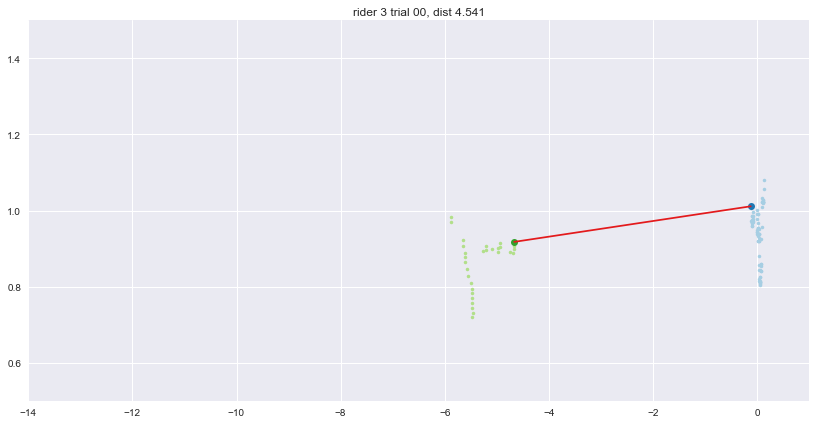

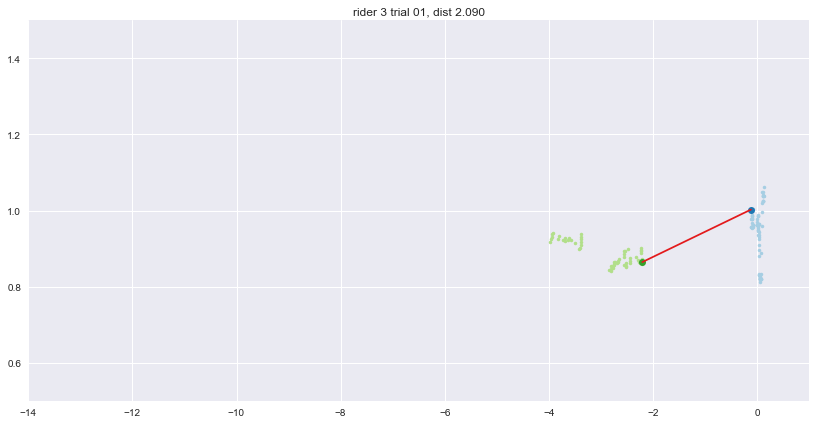

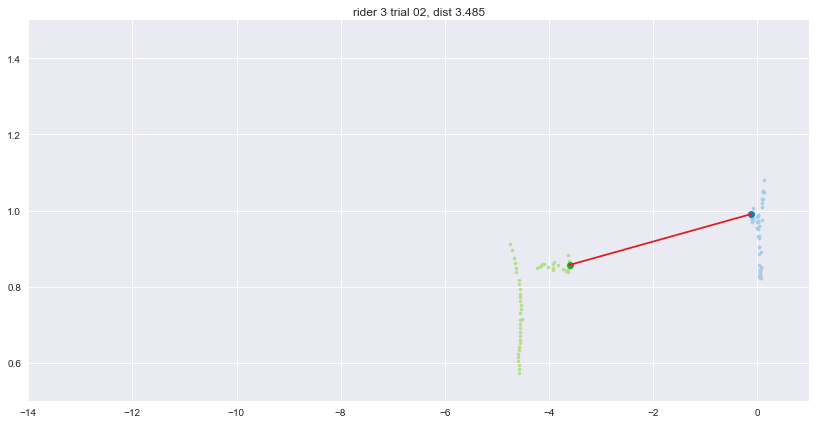

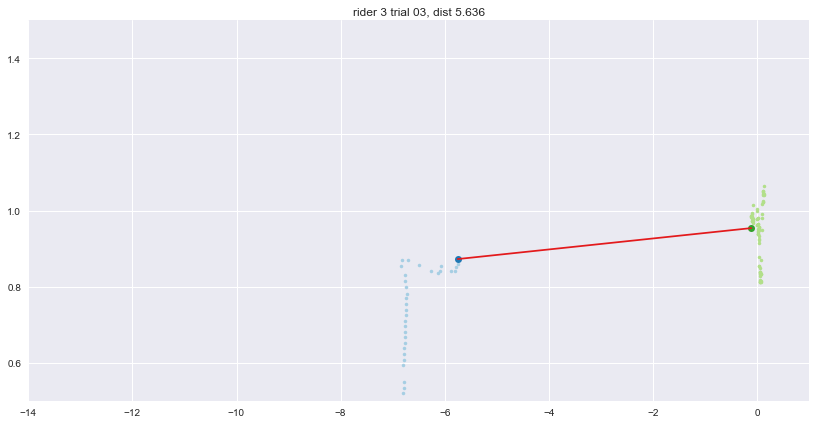

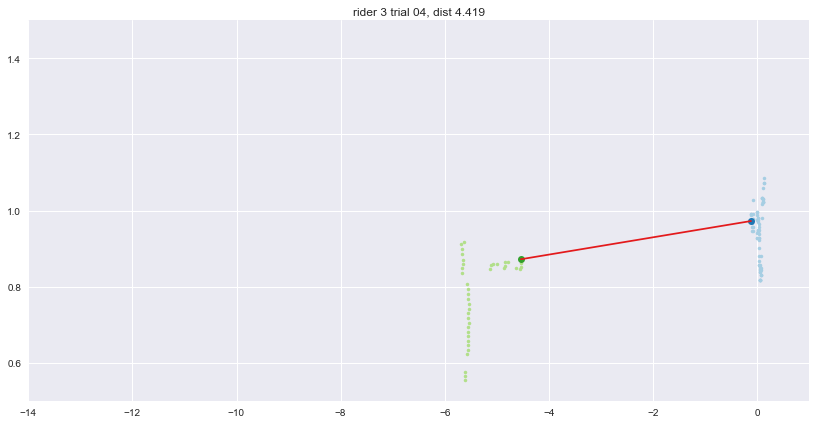

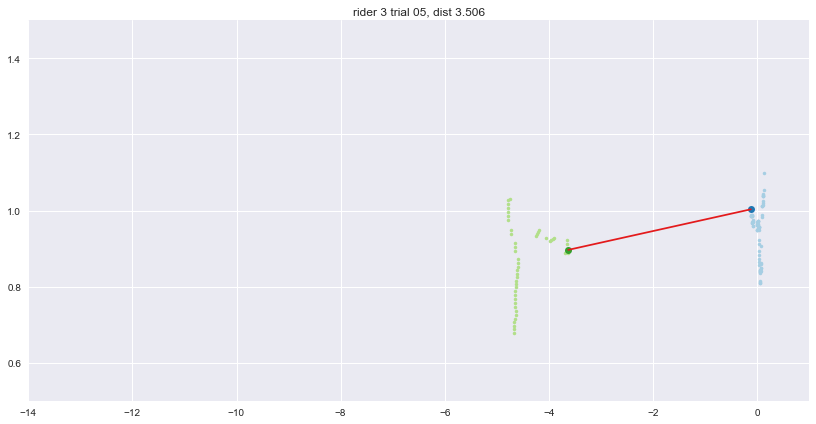

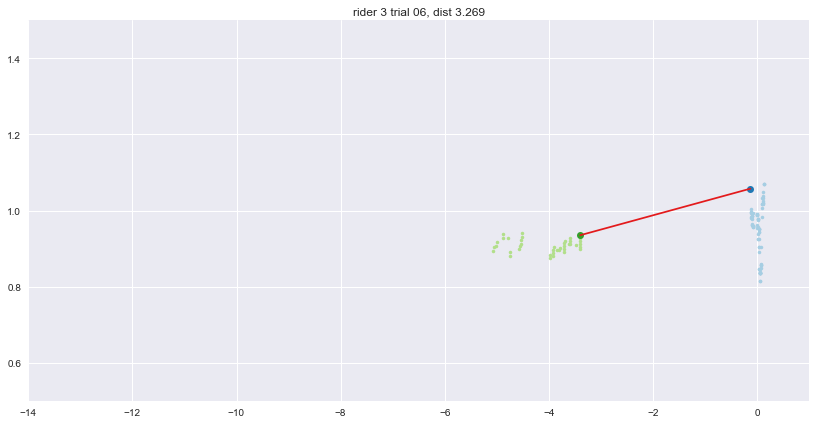

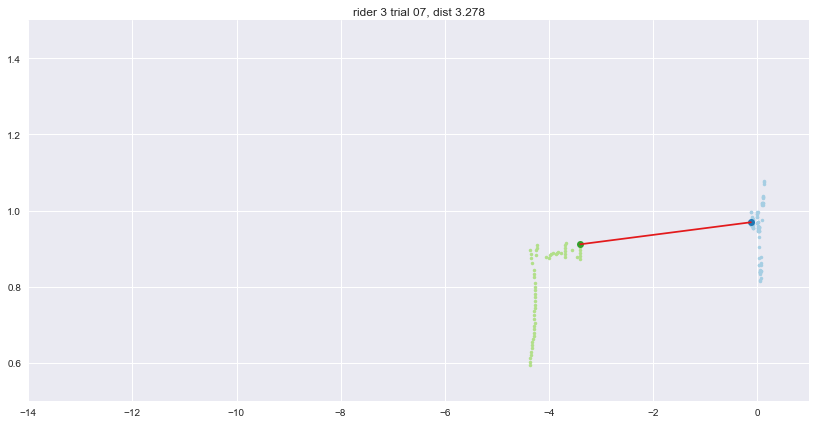

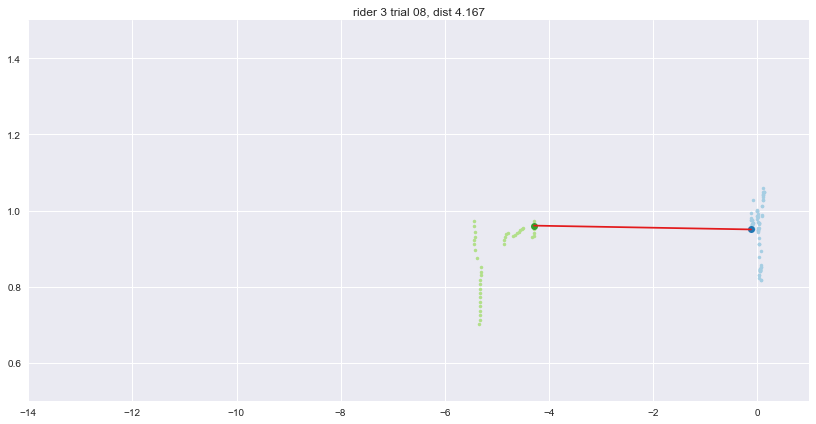

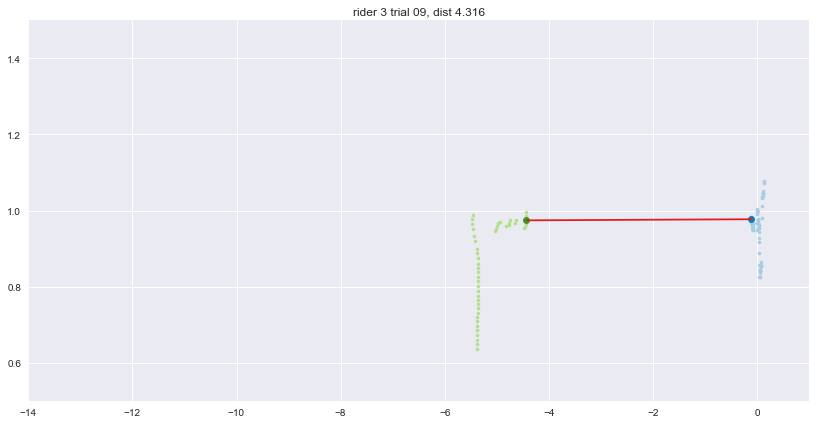

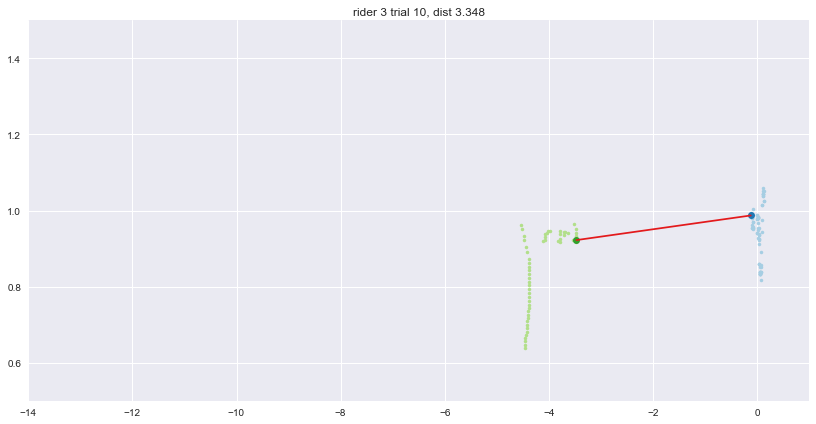

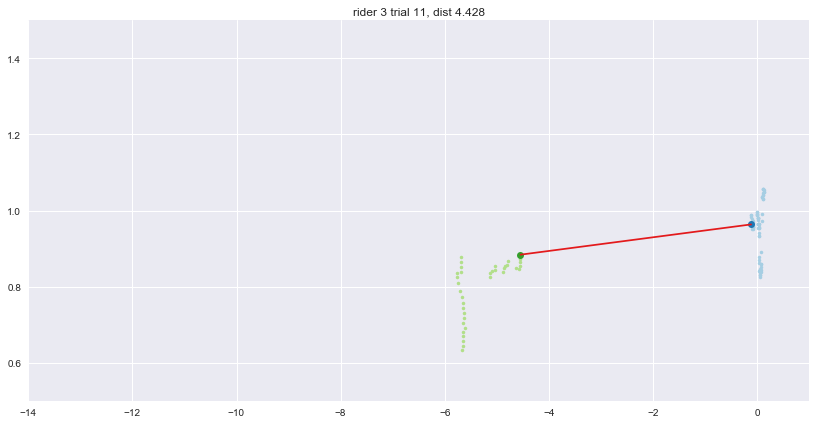

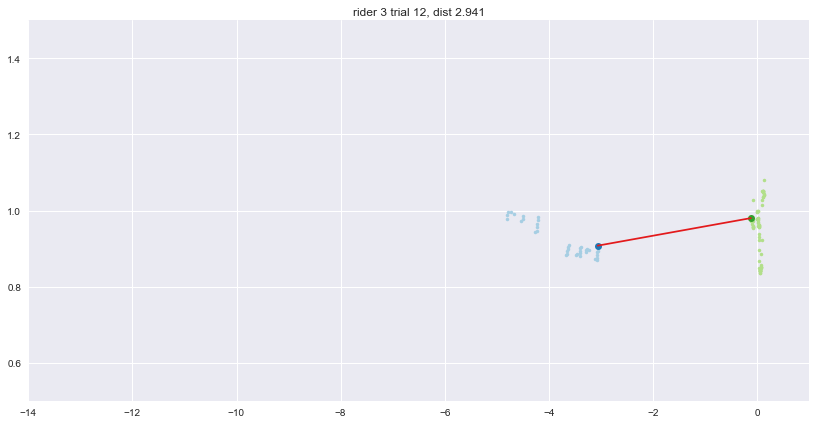

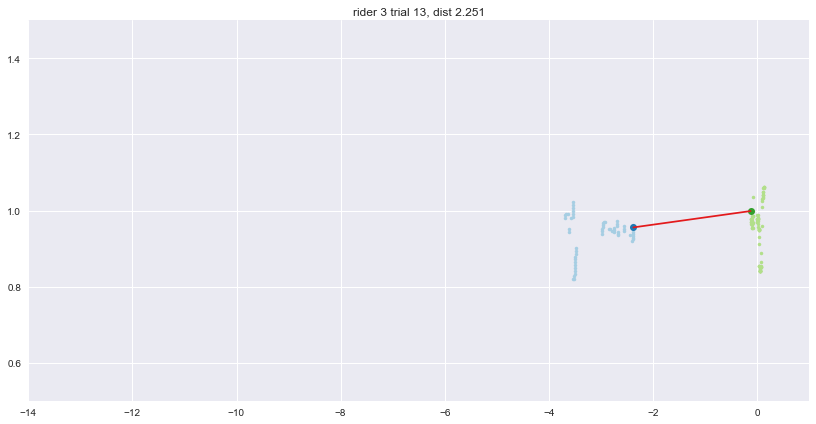

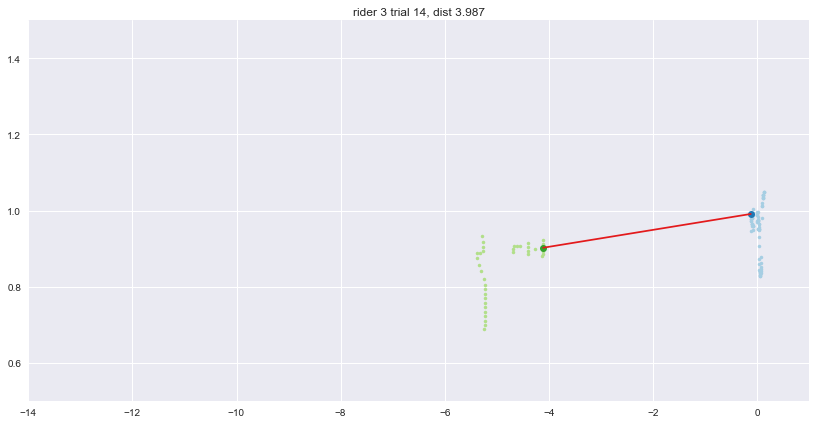

In [97]:
import seaborn as sns

plt.close()
for rid, tid in itertools.product(range(3, 4), range(15)):
    if (rid == 0) and (tid == 1):
        continue
        
    record = records[rid]
    trial = record.trial[tid]
    
    ev_time, _, _ = trial.steer_event_parameters()
    index = record.lidar.frame_index(ev_time[0])
    
    # get index before time 0
    #index = np.insert(index, 0, index[0] - 1)
    
    frames = record.lidar[index]
    x, y = frames.cartesian(xlim=(-19, 1),
                            ylim=(0.5, 3))
    
    # get clusters
    a, b = cluster(x, y)
    
    # calculate minumum distance
    # TODO: account for wheel radius and LIDAR height
    d, pa, pb = bcp_brute(a, b)
    pd = np.vstack((pa, pb))
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    colors = sns.color_palette('Paired', 10)
    ax.plot(*zip(*a), '.', color=colors[0])
    ax.plot(*zip(*b), '.', color=colors[2])
    ax.plot(*pa, 'o', color=colors[1])
    ax.plot(*pb, 'o', color=colors[3])
    ax.plot(*zip(*pd), color=colors[5])
    
    ax.set_xlim((-14, 1))
    ax.set_ylim((0.5, 1.5))
    
    ax.set_title('rider {} trial {:02d}, dist {:0.03f}'.format(
        rid, tid, d))
    
plt.show()